In [ ]:
import pandas as pd
import numpy as np
import random
import string
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from datasets import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import evaluate
from jiwer import wer
from nltk.translate.bleu_score import SmoothingFunction
from difflib import SequenceMatcher
import torch

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('/kaggle/input/tune300/tune.tsv', sep='\t', header=None)
df.head()

,0,1
0,"' ( 1990 ) was the second sequel to appear , t...",' ( 1990 ) was the second sequel to appear . <...
1,' Maolain ' said to be diminutive of ' bald ' ...,' Maolain ' said to be diminuative of ' bald '...
2,' Skycruiser ' seating is available on the rem...,' Skycruiser ' seating is available on Boeing ...
3,' This group of nobles had supported the Engli...,' This group of nobles had supported the Engli...
4,' was a 14 - issue ongoing series by Devil 's ...,' was a fourteen issue ongoing series by Devil...


In [ ]:
train_data = pd.read_csv('/kaggle/input/tune300/tune.tsv', sep='\t', header=None,usecols=[0], names=['correct'])
val_data = pd.read_csv('/kaggle/input/validation300/validation.tsv', sep='\t', header=None,usecols=[0], names=['correct'])
test_data = pd.read_csv('/kaggle/input/test300/test.tsv', sep='\t', header=None,usecols=[0], names=['correct'])

train_data.head(), val_data.head(), test_data.head()


(                                             correct
 0  ' ( 1990 ) was the second sequel to appear , t...
 1  ' Maolain ' said to be diminutive of ' bald ' ...
 2  ' Skycruiser ' seating is available on the rem...
 3  ' This group of nobles had supported the Engli...
 4  ' was a 14 - issue ongoing series by Devil 's ...,
                                              correct
 0  ' Lauren Rose Crace ' , born 25th of May 1986 ...
 1  '' A Living Library '' was Bonnie Sherk 's wor...
 2  '' All Singing , All Dancing '' is the elevent...
 3  '' Already Gone '' is a mid-tempo ballad in wh...
 4  '' Bafana Bafana '' is a nickname given to the...,
                                              correct
 0  ' Bandolier - Budgie ' , a free iTunes app for...
 1  ' Eden Black ' was grown from seed in the late...
 2  ' Wilson should extend his stint on The Voice ...
 3  '' '' New York Mining Disaster 1941 '' '' was ...
 4  '' ADAPTOGENS : Herbs for Strength , Stamina ,...)

In [ ]:
def introduce_typos(sentence, error_rate=0.10):
    sentence = list(sentence)
    num_typos = max(1, round(len(sentence) * error_rate))

    for _ in range(num_typos):
        action = random.choice(['replace', 'delete', 'swap', 'duplicate', 'insert', 'vowel_sub', 'consonant_sub'])
        idx = random.randint(0, len(sentence) - 1)

        if action == 'replace':
            sentence[idx] = random.choice(string.ascii_lowercase)

        elif action == 'delete' and len(sentence) > 1:
            del sentence[idx]

        elif action == 'swap' and idx < len(sentence) - 1:
            sentence[idx], sentence[idx + 1] = sentence[idx + 1], sentence[idx]

        elif action == 'duplicate':
            sentence.insert(idx, sentence[idx])

        elif action == 'insert':
            sentence.insert(idx, random.choice(string.ascii_lowercase))

        elif action == 'vowel_sub':
            vowels = 'aeiou'
            vowel_indices = [i for i, char in enumerate(sentence) if char in vowels]
            if vowel_indices:
                vi = random.choice(vowel_indices)
                sentence[vi] = random.choice([v for v in vowels if v != sentence[vi]])

        elif action == 'consonant_sub':
            consonants = [c for c in string.ascii_lowercase if c not in 'aeiou']
            consonant_indices = [i for i, char in enumerate(sentence) if char in consonants]
            if consonant_indices:
                ci = random.choice(consonant_indices)
                sentence[ci] = random.choice([c for c in consonants if c != sentence[ci]])

    return ''.join(sentence)

In [ ]:
def prepare_data(df):
    df['misspelled'] = df['correct'].apply(lambda x: introduce_typos(x))
    df['correct'] = df['correct'].str.replace(r'<.*?>', '', regex=True)
    df['misspelled'] = df['misspelled'].str.replace(r'<.*?>', '', regex=True)
    return df[['misspelled', 'correct']]

In [ ]:
train_data = prepare_data(train_data)
val_data = prepare_data(val_data)
test_data = prepare_data(test_data)

print("Sample:")
display(train_data.sample(5))

Sample:


,misspelled,correct
1931,"I 1999 ,'' The ClokWorks '' on 12g hStyeet hda...","In 1999 , '' The ClockWorks '' on 12th Street ..."
4658,This was Bakrer 's first oppeaarnce ags Edgar ...,This was Barker 's first appearance as Edgar R...
1726,Hokart is a little perrturzyed when the gglowi...,Hokart is a little perturbed when the glowing ...
2100,Inn past years scudets hhave developed numegr...,"In past years , students have developed numero..."
2409,"Jing Fang ( , 78j -- 37 BC ) , born Li Fangl ...","Jing Fang ( , 78 -- 37 BC ) , born Li Fang ( 李..."


In [ ]:
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)
test_ds = Dataset.from_pandas(test_data)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def preprocess_function(examples):
    inputs = tokenizer(examples['misspelled'], max_length=128, truncation=True, padding="max_length")
    targets = tokenizer(examples['correct'], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = [[-100 if t == tokenizer.pad_token_id else t for t in target] for target in targets["input_ids"]]
    return inputs

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)
test_ds = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    warmup_steps=500,
    lr_scheduler_type="cosine",
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/tmp/ipykernel_31/41760874.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.943200,0.727618
2,0.756200,0.585424
3,0.667000,0.537064
4,0.621000,0.510871
5,0.567100,0.495850
6,0.522700,0.487686
7,0.489700,0.482533
8,0.459800,0.476976
9,0.446500,0.472705
10,0.436600,0.471063


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=4695, training_loss=0.5647548269286069, metrics={'train_runtime': 5156.4888, 'train_samples_per_second': 14.545, 'train_steps_per_second': 0.911, 'total_flos': 1.1417960448e+16, 'train_loss': 0.5647548269286069, 'epoch': 15.0})

In [ ]:
def calculate_cer(reference, hypothesis):
    matcher = SequenceMatcher(None, reference, hypothesis)
    return 1 - matcher.ratio()


In [ ]:
from evaluate import load

def evaluate_model(model, dataset, tokenizer, num_examples=100):
    model.eval()
    subset = dataset.select(range(min(num_examples, len(dataset))))

    references, predictions = [], []
    misspelled_inputs = []

    for example in subset:
        misspelled = example['misspelled']
        misspelled_inputs.append(misspelled)
        inputs = tokenizer(misspelled, return_tensors="pt", max_length=128, truncation=True).to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs, max_length=128)
        pred = tokenizer.decode(output[0], skip_special_tokens=True)
        references.append(example['correct'])
        predictions.append(pred)

    cer = [calculate_cer(ref, pred) for ref, pred in zip(references, predictions)]

    wer_score = wer(references, predictions)

    rouge = load("rouge")
    rouge_scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    return {
        'avg_cer': sum(cer) / len(cer),
        'wer': wer_score,
        'rougeL': rouge_scores["rougeL"],
        'samples': list(zip(misspelled_inputs, predictions, references))
    }


In [ ]:
results = evaluate_model(model, test_ds, tokenizer)

print("\nEvaluation Metrics:")
for k, v in results.items():
    if k != 'samples':
        print(f"{k}: {v:.4f}")


Evaluation Metrics:
avg_cer: 0.1003
wer: 0.1480
rougeL: 0.8510


In [ ]:
print("\nSample Predictions:")
for i, (misspelled, pred, ref) in enumerate(results['samples'][5:10]):
    print(f"Example {i+1}:")
    print(f"  Misspelled: {misspelled}")
    print(f"  Predicted : {pred}")
    print(f"  Correct   : {ref}")
    print()



Sample Predictions:
Example 1:
  Misspelled: '' Aeroydnamic '' is an unstrumentdal sang bq Daft Pukn that is patticuladly well - nkonw for its robotic guitar silo ..
  Predicted : '' Aerodynamic '' is an unstrumental song by Daft Punk that is particularly well - known for its robotic guitar solo .
  Correct   : '' Aerodynamic '' is an instrumental song by Daft Punk that is particularly well - known for its robotic guitar solo .

Example 2:
  Misspelled: '' Afteb a lawsuit byl Rey Lynch for allegedly not baying chim , nhq compamy was foreclosed b ySecurity Pacific Bank in oNvember 1991 jwith all of its assots svold gyy June 199 2.
  Predicted : '' Following a lawsuit by Rey Lynch for allegedly not paying his mortgage , the company was closed by Security Pacific Bank in November 1991 with all of its assets suspended by June 1992 .
  Correct   : '' After a lawsuit by Ray Lynch for allegedly not paying him , the company was foreclosed by Security Pacific Bank on November 1991 with all of 

In [ ]:
def plot_metrics(metrics):
    df = pd.DataFrame({
        'Metric': ['CER', 'WER', 'ROUGE-L'],
        'Value': [metrics['avg_cer'], metrics['wer'], metrics['rougeL']]
    })

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Metric', y='Value', data=df)

    for i, v in enumerate(df['Value']):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

    plt.ylim(0, 1)
    plt.title('Model Evaluation Metrics', fontsize=14)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()


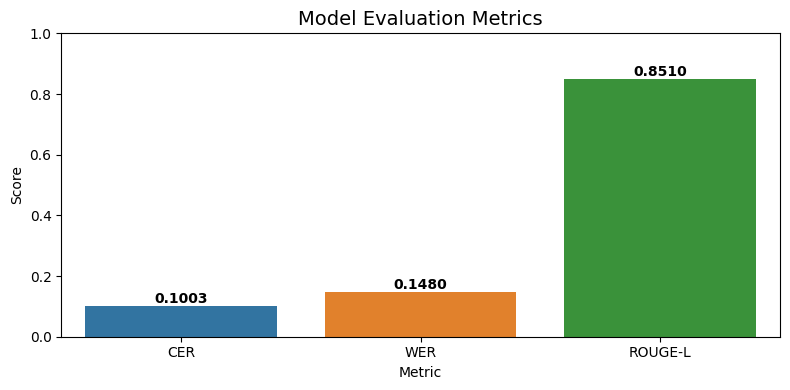

In [ ]:
plot_metrics(results)
